# Import the necessary libraries

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import re, string, unicodedata
import contractions
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# download stopwords
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded to 2 decimal places

Load the Dataset

In [ ]:
tweets = pd.read_csv('Tweets.csv')
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.70,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.35,NaN,0.00,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.00,Customer Service Issue,1.00,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.00,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.00,Customer Service Issue,0.67,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


EDA

In [ ]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.70,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
tweets.shape

(14640, 15)

In [ ]:
tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
tweets.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [ ]:
np.sum(tweets.isnull().any(axis=1))

14638

In [ ]:
print('Count of columns in the data is:  ', len(tweets.columns))
print('Count of rows in the data is:  ', len(tweets))

Count of columns in the data is:   15
Count of rows in the data is:   14640


In [ ]:
# convert all columns with dtype object into category to save memory
for col in tweets.columns[ tweets.dtypes=='object']:
     tweets[col] =  tweets[col].astype('category')

In [ ]:
# convert tweet_id into a category to save memory
tweets['tweet_id'] = tweets['tweet_id'].astype('category')

In [ ]:
# convert tweet_created into a datetime to allow for time series analysis
tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])
tweets['tweet_created'] = tweets['tweet_created'].astype('datetime64[ns]')

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  category      
 1   airline_sentiment             14640 non-null  category      
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   category      
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  category      
 6   airline_sentiment_gold        40 non-null     category      
 7   name                          14640 non-null  category      
 8   negativereason_gold           32 non-null     category      
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  category      
 11  tweet_coord                 

Numerical variables

In [ ]:
# show summary of all numerical variables
tweets.describe().T

,count,mean,std,min,25%,50%,75%,max
airline_sentiment_confidence,14640.00,0.90,0.16,0.34,0.69,1.00,1.00,1.00
negativereason_confidence,10522.00,0.64,0.33,0.00,0.36,0.67,1.00,1.00
retweet_count,14640.00,0.08,0.75,0.00,0.00,0.00,0.00,44.00


Categorical variables

In [ ]:
# show summary of all categorical variables
tweets.describe(include=['category']).T

,count,unique,top,freq
tweet_id,14640,14485,570281470507352064,2
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_location,9907,3081,"Boston, MA",157


Datetime variables

In [ ]:
# show summary of datetime variable
tweets.describe(include=['datetime']).T

,count,unique,top,freq,first,last
tweet_created,14640,14247,2015-02-24 17:54:34,5,2015-02-17 07:36:05,2015-02-24 19:53:37


Number of tweets by day

In [ ]:
# show number of tweets by day
by_date = tweets.groupby(pd.Grouper(key='tweet_created', axis=0, freq='D')).count()['tweet_id']
print(by_date)

tweet_created
2015-02-17     953
2015-02-18    1416
2015-02-19    1298
2015-02-20    1512
2015-02-21    1418
2015-02-22    2392
2015-02-23    3515
2015-02-24    2136
Freq: D, Name: tweet_id, dtype: int64


Data visualizations

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, hue=None, perc=False, n=None):
    total = len(data[feature])  # length of the column

    ax = sns.countplot(
        data=data,
        x=feature,
        hue=hue,
        palette='viridis',
        order = data[feature].value_counts().index,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()

In [ ]:
# import the figure size for the visualizations
from matplotlib import rcParams

Distribution of sentiment across all the tweets

In [ ]:
# show number of tweets by sentiment
tweets.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

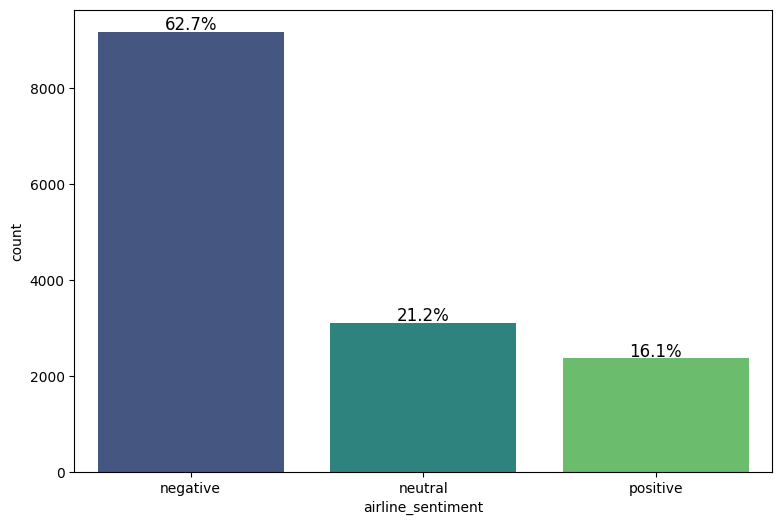

In [ ]:
# create labled barplot for number of tweets by sentiment
rcParams['figure.figsize'] = 9,6
labeled_barplot(tweets,'airline_sentiment',perc=True)

Distribution of all tweets among each airline

In [ ]:
# show number of tweets by airline
tweets.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

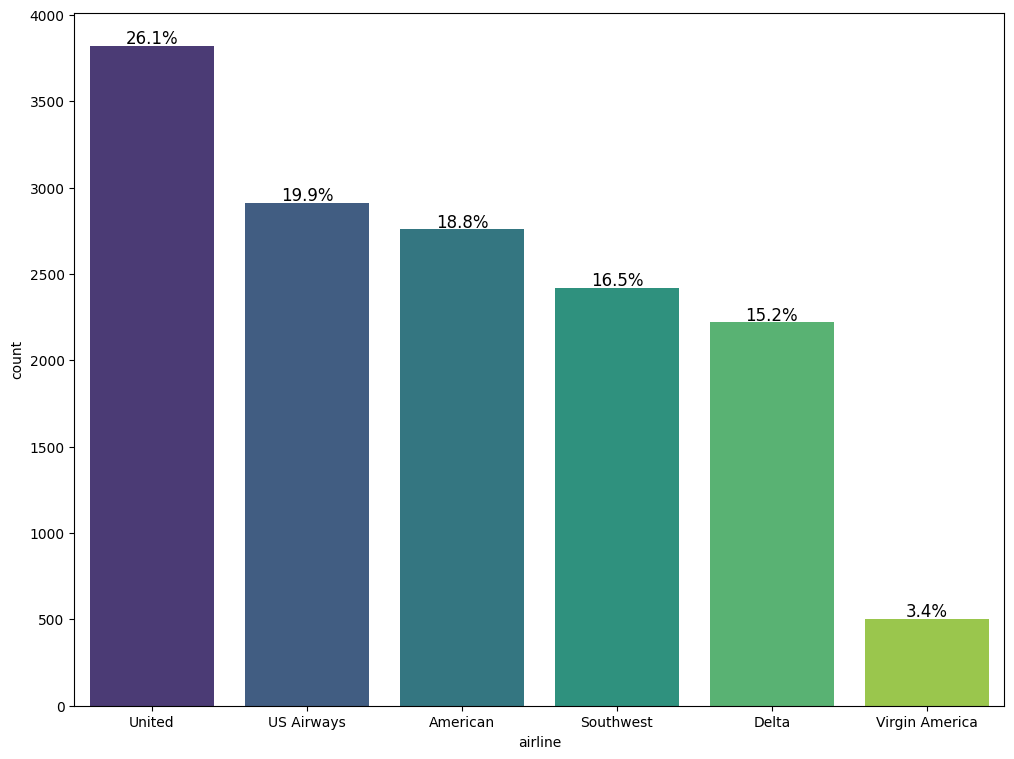

In [ ]:
# create labeled barplot of number of tweets by airline
rcParams['figure.figsize'] = 12,9
labeled_barplot(tweets,'airline',perc=True)

Distribution of sentiment of tweets for each airline

In [ ]:
# show number of tweets by sentiment per airline
tweets.groupby('airline')['airline_sentiment'].value_counts()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: airline_sentiment, dtype: int64

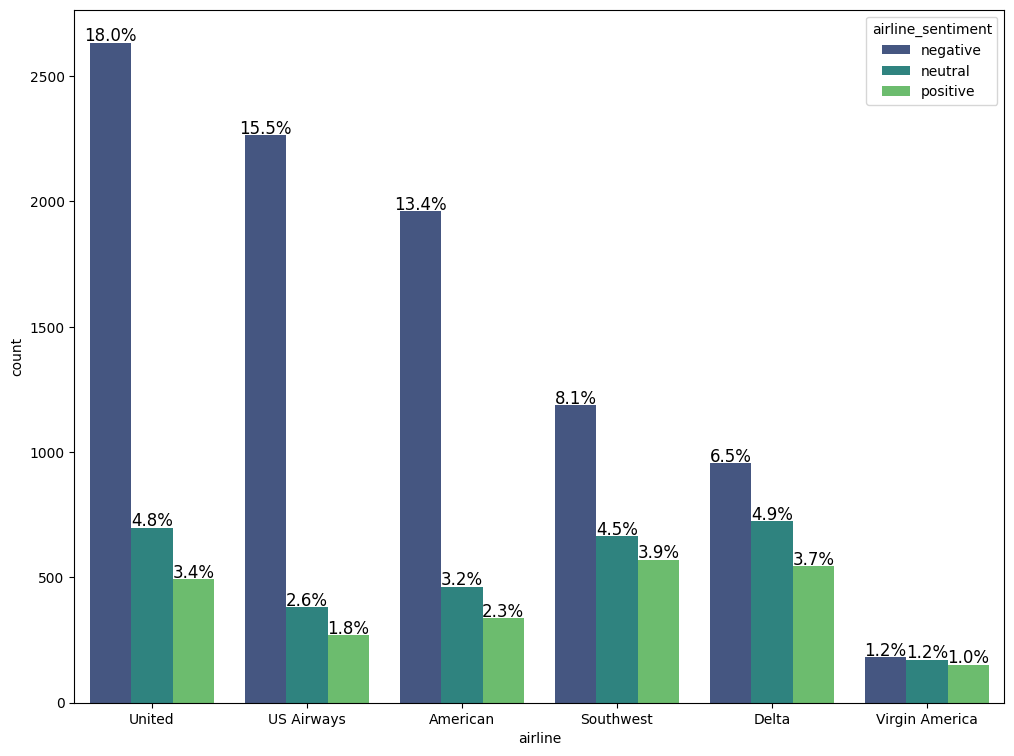

In [ ]:
# create labeled barplot for number of tweets by sentiment per airline
labeled_barplot(tweets,'airline','airline_sentiment',perc=True)

Distribution of all the negative reasons

In [ ]:
# show number of tweets by reason for negative sentiment
tweets.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

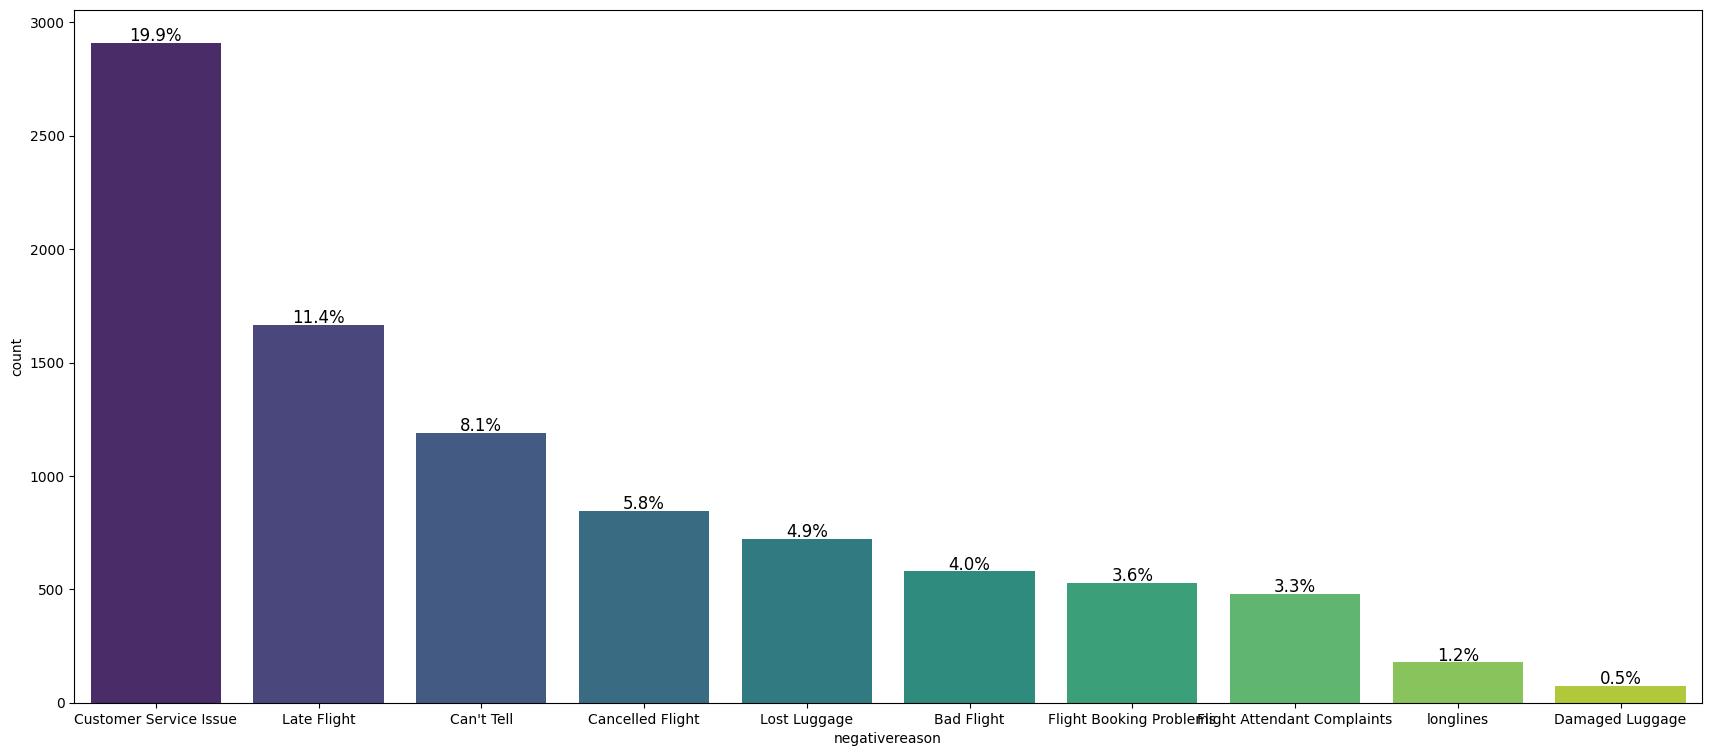

In [ ]:
# create labeled barplot for number of tweets per reason for negative sentiment
rcParams['figure.figsize'] = 21,9
labeled_barplot(tweets,'negativereason',perc=True)

Word cloud of tweets of positive sentiment

In [ ]:
def wordcloud(tweets):
  words = ' '.join(tweets['text'])
  cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
  wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
  plt.figure(1,figsize=(12, 12))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

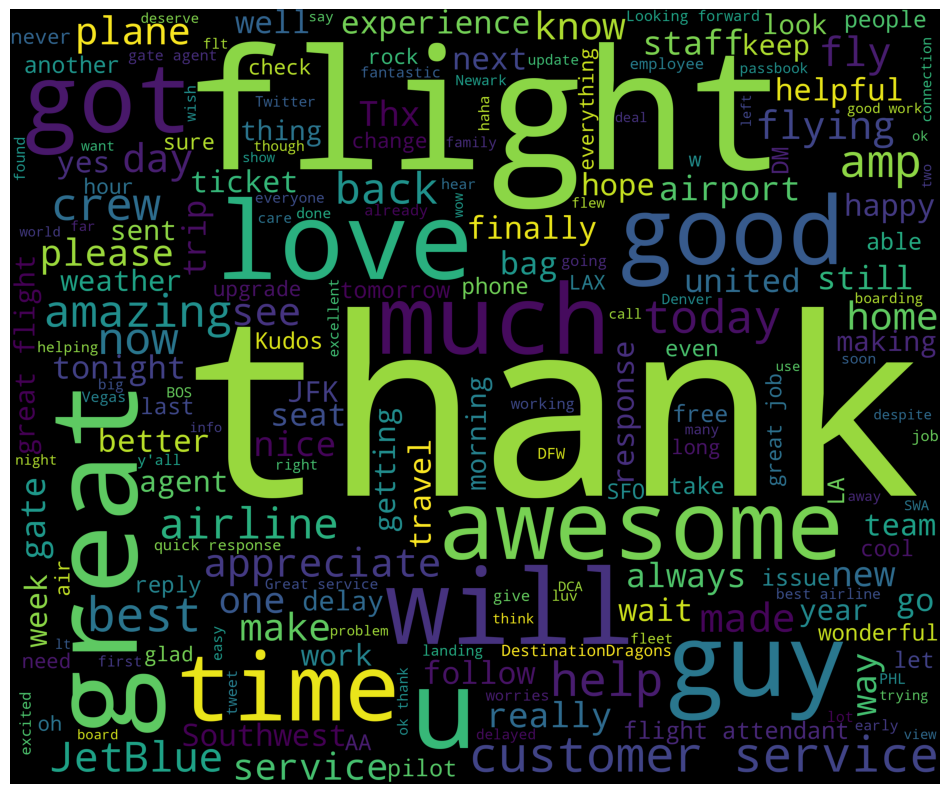

In [ ]:
# create word cloud for positive tweets
pos_tweets = tweets[tweets['airline_sentiment']=='positive']
wordcloud(pos_tweets)

Word cloud of tweets of -ve sentiment

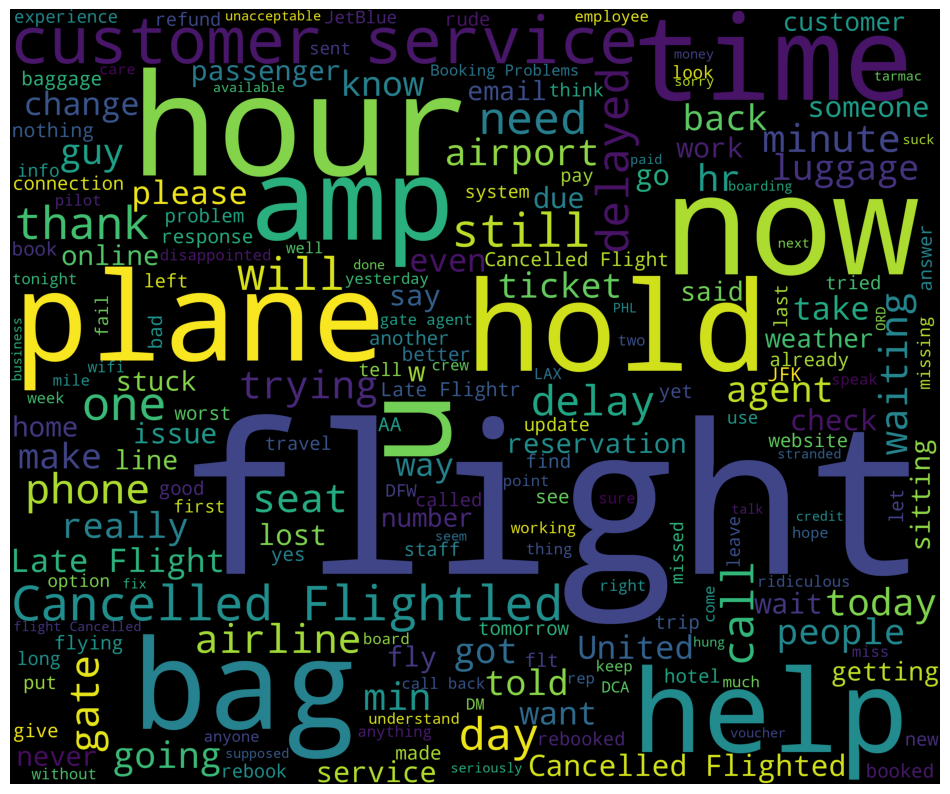

In [ ]:
# create world cloud for negative tweets
neg_tweets = tweets[tweets['airline_sentiment']=='negative']
wordcloud(neg_tweets)

Follow-on data cleaning

In [ ]:
column_list = tweets.columns.to_list()

In [ ]:
# identify columns used for model building
columns = ['text','airline_sentiment']

In [ ]:
# identify columns to be dropped
drop_columns = [col for col in column_list if col not in columns]
print(drop_columns)

['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [ ]:
# drop all other columns except “text” and “airline_sentiment”
tweets_model = tweets.drop(columns = drop_columns)

In [ ]:
# confirm new shape of the dataset
tweets_model.shape

(14640, 2)

In [ ]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (non-turncated text column.)
#print head of new dataset
tweets_model.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


Data pre-processing

Clean text

In [ ]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text):
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_url(text)
    text = remove_mention(text)
    return text
tweets_model['text'] = tweets_model['text'].apply(lambda x: clean_text(x))
tweets_model.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


Tokenization

In [ ]:
tweets_model['text'] = tweets_model.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # tokenization of data
tweets_model.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


Normalize text

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = stopwords.words('english')
custom_remove_list = ['flight']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

# remove the non-ASCII characters
def remove_non_ascii(words):

    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):

    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# remove the hashtags
def remove_hash(text):

   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# remove the punctuations
def remove_punctuation(words):

    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# remove the stop words
def remove_stopwords(words):

    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

tweets_model['text'] = tweets_model.apply(lambda row: normalize(row['text']), axis=1)
tweets_model.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


Supervised Learning

Bag of Words (Count Vectorizer)

In [ ]:
# set independent variable for classification model
targets = sorted(tweets_model.airline_sentiment.unique().to_list())
print(targets)

['negative', 'neutral', 'positive']


In [ ]:
# set the max number of features at 1000
count_vec = CountVectorizer(max_features=1000)
# convert text to numbers with CountVectorizer
data_features_count = count_vec.fit_transform(tweets_model['text'])
# convert the data features to array
data_features_count = data_features_count.toarray()

In [ ]:
# show shape of the feature vector
data_features_count.shape

(14640, 1000)

In [ ]:
# split data into training and testing set
X_count = data_features_count
y = tweets_model.airline_sentiment
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.25, shuffle=False, random_state=42)

In [ ]:
# find the optimal number of base learners using k-fold cross-validation (CV)
import numpy as np
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_count, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

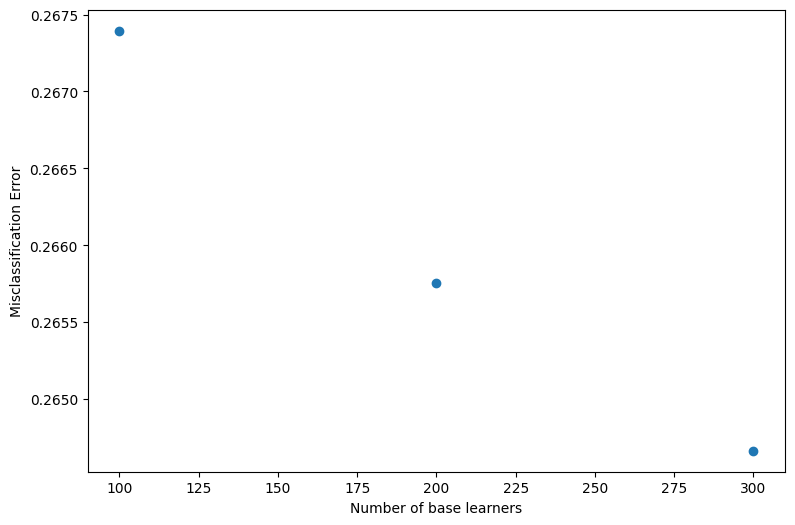

In [ ]:
# set figure size
rcParams['figure.figsize'] = 9,6
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# train the best model
clf_count = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf_count.fit(X_train_count, y_train)
clf_count.score(X_test_count, y_test)
count_predicted = clf_count.predict(X_test_count)

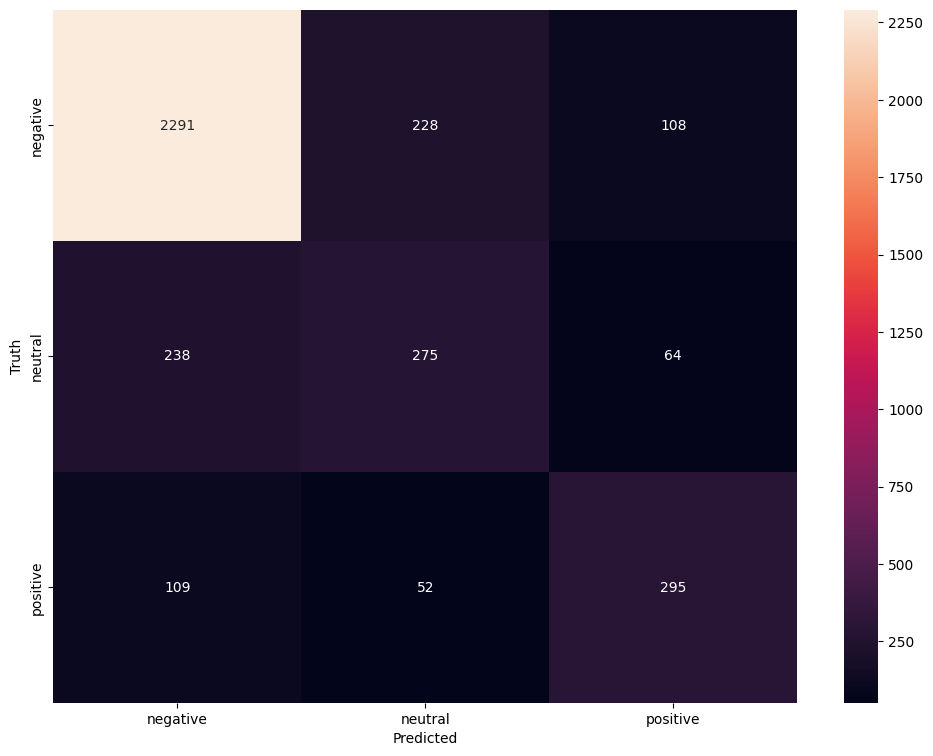

In [ ]:
from sklearn.metrics import confusion_matrix
#create confusion matrix for Count Vectorizer
cm_count=confusion_matrix(y_test,count_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_count,annot=True,fmt='d',xticklabels=targets , yticklabels= targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier  # Example classifier, import your classifier if different


In [ ]:
all_features_count = count_vec.get_feature_names_out()  # Get feature names from the CountVectorizer
top_features_count = ''  # Initialize a string to store the top 40 features
feat = clf_count.feature_importances_
features = np.argsort(feat)[::-1]

for i in features[0:40]:
    top_features_count += all_features_count[i]
    top_features_count += ', '

top_features_count = top_features_count[:-2]  # Remove the trailing comma and space


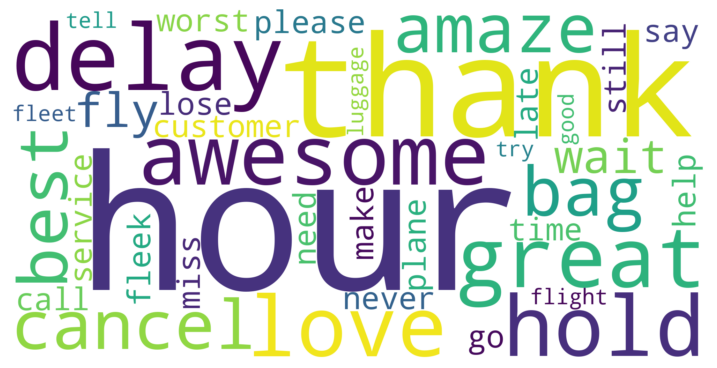

In [ ]:
from wordcloud import WordCloud
# create word cloud
wordcloud_count = WordCloud(background_color="white",colormap='viridis',width=2000,
                          height=1000).generate(top_features_count)

# show word cloud
plt.imshow(wordcloud_count, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [ ]:
# saving variables for model
y_train_count = y_train
y_test_count = y_test

Tf-Idf Vectorizer.

In [ ]:
# set the max number of features at 1000
tfidf_vec = TfidfVectorizer(max_features=1000)
# convert test to numbers with TfidfVectorizer
data_features_idf = tfidf_vec.fit_transform(tweets_model['text'])
# convert the data features to array
data_features_idf = data_features_idf.toarray()

In [ ]:
# show shape of the feature vector
data_features_idf.shape

(14640, 1000)

In [ ]:
# split data into training and testing set
X_idf = data_features_idf
y = tweets_model.airline_sentiment
X_train_idf, X_test_idf, y_train, y_test = train_test_split(X_idf, y, test_size=0.25, shuffle=False, random_state=42)

In [ ]:
# find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_idf, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

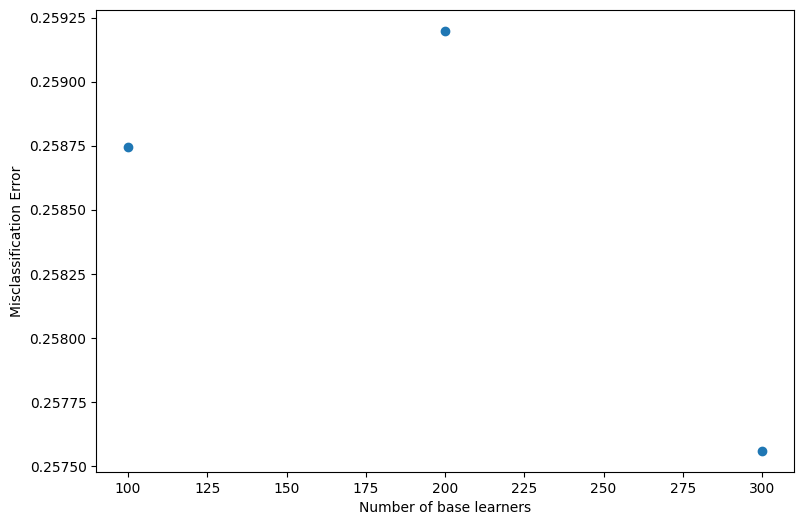

In [ ]:
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# train the best model
clf = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf.fit(X_train_idf, y_train)
clf.score(X_test_idf, y_test)
tf_idf_predicted = clf.predict(X_test_idf)

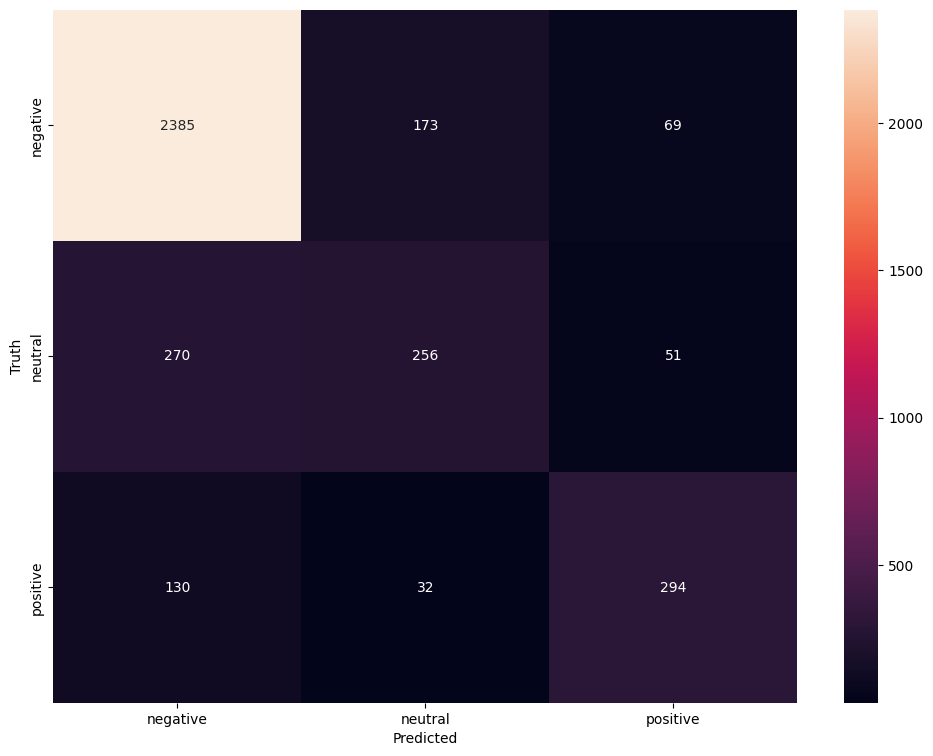

In [ ]:
# create confusion matrix for TF-IDF Vectorizer
cm_tfidf=confusion_matrix(y_test , tf_idf_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_tfidf,annot=True,fmt='d',xticklabels=targets , yticklabels=targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
all_features = tfidf_vec.get_feature_names_out()  # Get feature names from the TF-IDF vectorizer
top_features = ''  # Initialize a string to store the top 40 features

feat = clf.feature_importances_
features = np.argsort(feat)[::-1]

for i in features[:40]:
    top_features += all_features[i]
    top_features += ', '

top_features = top_features[:-2]  # Remove the trailing comma and space


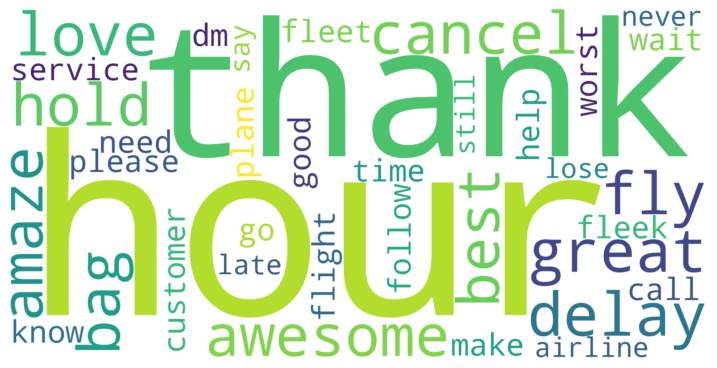

In [ ]:
from wordcloud import WordCloud
# create word cloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000,
                          height=1000).generate(top_features)

# show word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [ ]:
# saving variables for model
y_train_idf = y_train
y_test_idf = y_test

Recurring Neural Network

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder

In [ ]:
text_corpus = tweets_model.text
labels_corpus = tweets_model.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(text_corpus, labels_corpus, test_size=0.25, random_state=42)

In [ ]:
# set hyperparameters
num_words=4000
maxlen=1000

In [ ]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=num_words, char_level=False)

tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

len(sequences_train)

10980

In [ ]:
# pad sequences with 0s
X_train = pad_sequences(sequences_train, maxlen=maxlen)
X_test = pad_sequences(sequences_test, maxlen=maxlen)

print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)
print(type(X_train))

Shape of data tensor: (10980, 1000)
Shape of data test tensor: (3660, 1000)
<class 'numpy.ndarray'>


In [ ]:
# encode target variable
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.fit_transform(y_test)

Defining the model

In [ ]:
from keras import backend
import tensorflow as tf
backend.clear_session()

# set the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
def create_model(maxlen,num_words,num_categories):

    model = Sequential()

    model.add(Embedding(num_words,output_dim=100,input_length=maxlen,trainable=True))

    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(100)))

    model.add(Dropout(0.2))

    model.add(Dense(128,activation='relu'))

    model.add(BatchNormalization())

    model.add(Dense(64,activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(32,activation='relu'))

    model.add(Dense(num_categories, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
model=create_model(maxlen,num_words,tweets_model.airline_sentiment.nunique())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         400000    
                                                                 
 batch_normalization (Batch  (None, 1000, 100)         400       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 200)               160800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               5

In [ ]:
history = model.fit(X_train, y_train_label, epochs=5, validation_split=0.25)

Epoch 1/5
258/258 [==============================] - 563s 2s/step - loss: 0.7718 - accuracy: 0.6805 - val_loss: 1.0249 - val_accuracy: 0.3118
Epoch 2/5
258/258 [==============================] - 603s 2s/step - loss: 0.5400 - accuracy: 0.7860 - val_loss: 0.5989 - val_accuracy: 0.7486
Epoch 3/5
258/258 [==============================] - 602s 2s/step - loss: 0.4044 - accuracy: 0.8454 - val_loss: 0.6166 - val_accuracy: 0.7446
Epoch 4/5
258/258 [==============================] - 561s 2s/step - loss: 0.3009 - accuracy: 0.8856 - val_loss: 0.7774 - val_accuracy: 0.7366
Epoch 5/5
258/258 [==============================] - 596s 2s/step - loss: 0.2432 - accuracy: 0.9086 - val_loss: 0.8384 - val_accuracy: 0.7490


Model evaluation on training data

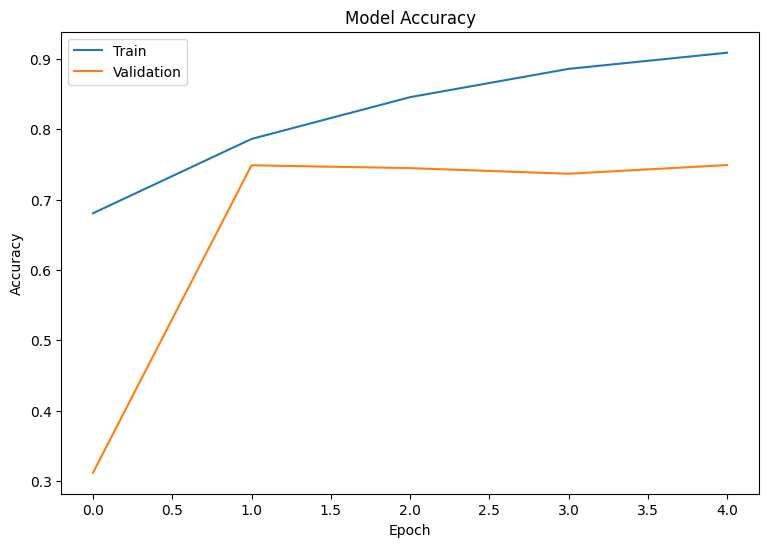

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#creating a dictionary to map model predictions to each sentiment
class_dict = {0:'negative',
 1:'neutral',
 2:'positive'}

In [ ]:
#making predictions on the test data
y_pred_test = model.predict(X_test)

#converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

115/115 [==============================] - 62s 496ms/step


In [ ]:
#creating a dataframe of model predictions
tweets = pd.DataFrame({"Labels":y_pred_test_classes})

#replacing predictions with sentiments
label_tweets = tweets.replace({"Labels":class_dict})

#converting dataframe to array
y_pred_test_classes = label_tweets.to_numpy()

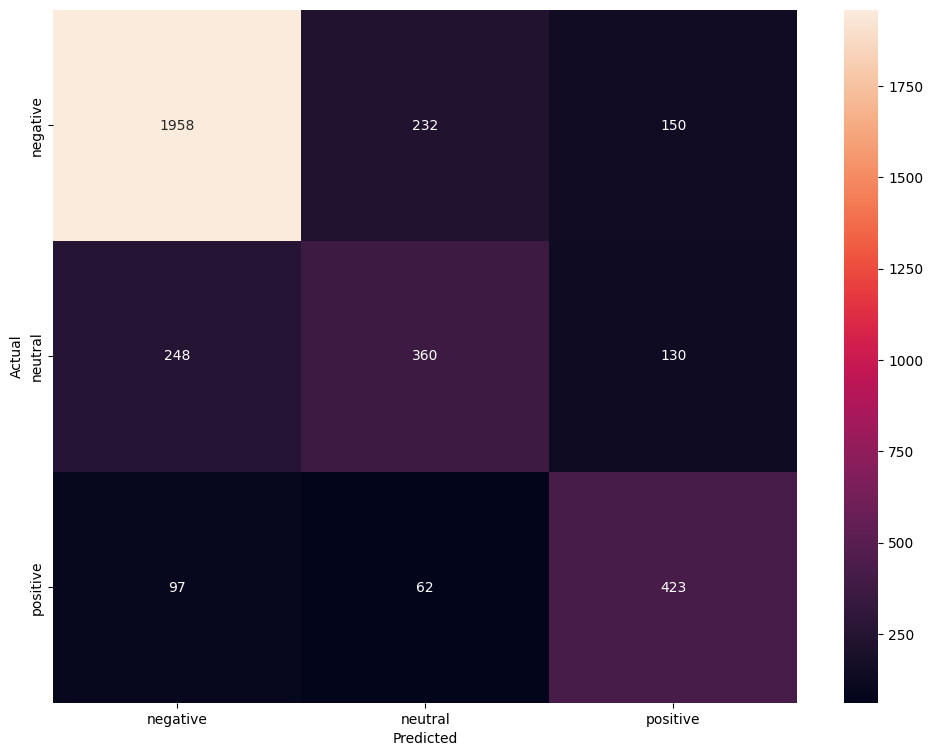

In [ ]:
#plotting the heatmap using confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(12,9))
sns.heatmap(cm_rnn, annot=True,  fmt='.0f', xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Conclusion

In [ ]:
# provide a classification report on the Count Vectorizer model
print("Random Forest model trained with Count Vectorizer data")
print(" ")
print(classification_report(y_test_count , count_predicted, target_names = targets))
print(" ")

# provide a classification report on the TF-IDF Vectorizer model
print("Random Forest model trained with TF-IDF Vectorizer data")
print(" ")
print(classification_report(y_test_idf , tf_idf_predicted, target_names = targets))
print(" ")

# provide the classification report on the RNN model
print("Recurring Neural Network (RNN) model")
print(" ")
print(classification_report(y_test, y_pred_test_classes))

Random Forest model trained with Count Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      2627
     neutral       0.50      0.48      0.49       577
    positive       0.63      0.65      0.64       456

    accuracy                           0.78      3660
   macro avg       0.67      0.67      0.67      3660
weighted avg       0.78      0.78      0.78      3660

 
Random Forest model trained with TF-IDF Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      2627
     neutral       0.56      0.44      0.49       577
    positive       0.71      0.64      0.68       456

    accuracy                           0.80      3660
   macro avg       0.71      0.67      0.68      3660
weighted avg       0.79      0.80      0.79      3660

 
Recurring Neural Network (RNN) model
 
              precision    recall  f1-score   support

    negative       0.85  

In [ ]:
!pip install gradio


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load a model from Google Drive using a relative path
model_path = "/content/drive/My Drive/Gradio_Models/Social_Media_Sentiment_Analysis.h5"


In [ ]:
# Load a model using an absolute path
model_path = "/content/Social_Media_Sentiment_Analysis.h5"


In [ ]:
!pip install gradio --upgrade


In [ ]:
import gradio as gr
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# Load your trained model and vectorizer
model = RandomForestClassifier()  # Load your trained Random Forest model
vectorizer = CountVectorizer()  # Use the appropriate vectorizer (Count Vectorizer or TF-IDF)

# Define a function to preprocess text
def preprocess(text):
    # Tokenization
    words = word_tokenize(text)

    # Lowercasing
    words = [word.lower() for word in words]

    # Remove punctuation and non-alphanumeric characters
    words = [re.sub(r'[^\w\s]', '', word) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join the words back into a single string
    preprocessed_text = ' '.join(words)

    return preprocessed_text

# Define a function for model prediction
def predict_sentiment(text_input):
    # Preprocess the input text
    preprocessed_text = preprocess(text_input)

    # Vectorize the preprocessed text
    text_vector = vectorizer.transform([preprocessed_text])

    # Make a prediction
    prediction = model.predict(text_vector)[0]

    # Map the prediction to sentiment labels
    sentiment_labels = ["negative", "neutral", "positive"]
    predicted_sentiment = sentiment_labels[prediction]

    return predicted_sentiment

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.inputs.Textbox(label="Enter text", type="text"),
    outputs=gr.outputs.Textbox(label="Sentiment Prediction", type="text"),
    live=True,
    title="Sentiment Analysis Web App",
    description="Enter text and get sentiment prediction.",
)

# Launch the Gradio interface
iface.launch()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-17-f5e39d3027c7>:57: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(label="Enter text", type="text"),
<ipython-input-17-f5e39d3027c7>:57: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(label="Enter text", type="text"),
<ipython-input-17-f5e39d3027c7>:57: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(label="Enter text", type="text"),
<ipython-input-17-f5e39d3027c7>:58: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import y

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7034df15564a0da789.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


TABLEAU DASHBOARD

In [ ]:
!pip install selenium
!pip install Pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.keys import Keys

# Install the Chrome WebDriver
!apt-get update # to update ubuntu to correctly run apt install
!apt install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,347 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,082 kB]
Get:13 https://ppa.launchpadcontent.net/c2d4u.

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-chromedriver is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 27 n

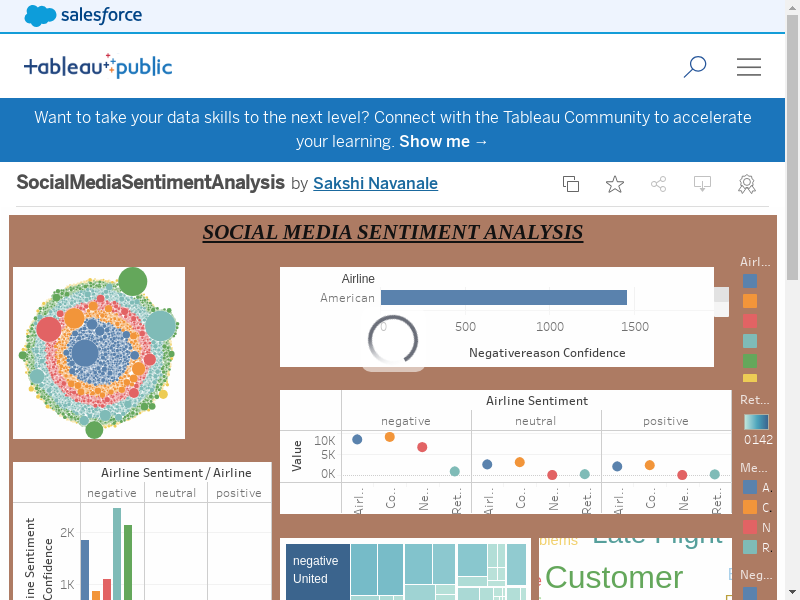

In [ ]:
from IPython.display import Image

# Set the URL of your Tableau Public dashboard
tableau_url = 'https://public.tableau.com/app/profile/sakshi.navanale/viz/SocialMediaSentimentAnalysis_16975653162680/Dashboard1'
# Install required packages and specify ChromeDriver version
!apt-get update
!apt-get install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install chromedriver-autoinstaller

from selenium import webdriver
import chromedriver_autoinstaller

chromedriver_autoinstaller.install()

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=chrome_options)
driver.get(tableau_url)

# Take a screenshot and save it
driver.save_screenshot('Dashboard1.png')

# Close the Chrome WebDriver
driver.quit()

# Display the screenshot in the Colab notebook
Image('Dashboard1.png')


Saving Dashboard 1.png to Dashboard 1.png


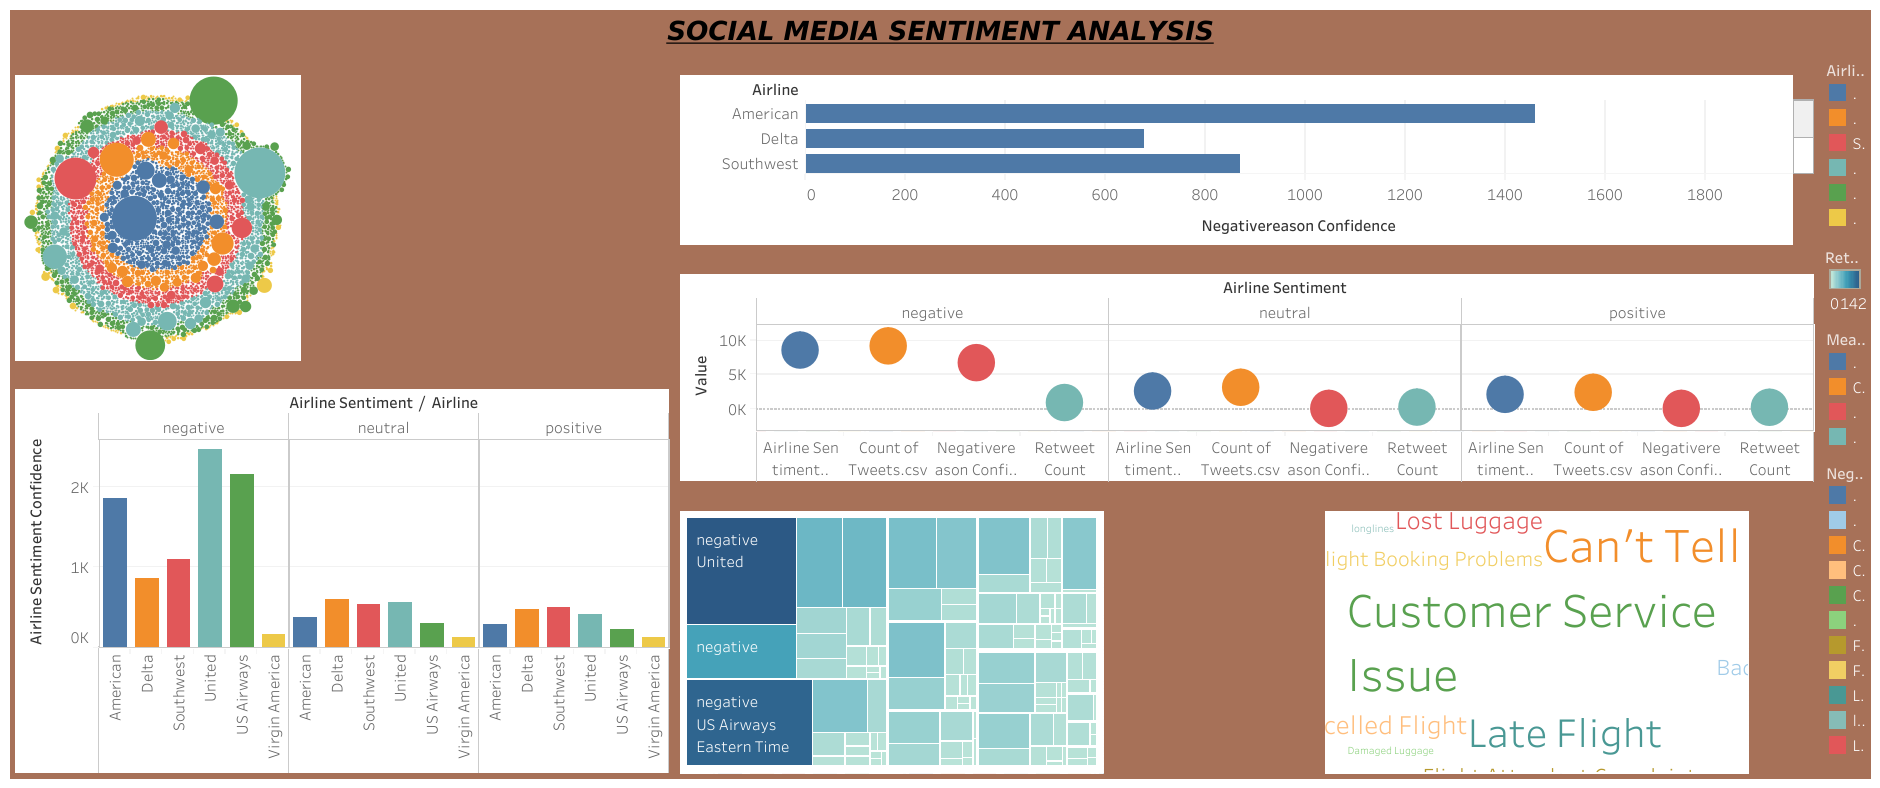

In [ ]:
from IPython.display import Image

# Upload the screenshot image to Colab
from google.colab import files
uploaded = files.upload()

# Display the uploaded image
for filename in uploaded.keys():
    display(Image(filename=filename))
